## Introduction to Hidden Markov Models with Python Networkx and Sklearn


<br>Author: Rakib Al-Fahad 
<br>Phd Candidate 
<br>The University of Memphis 
<br>Memphis, Tennessee 
<br>email: ralfahad@memphis.edu 
https://rakibalfahad.github.io/


### Ref:
http://www.blackarbs.com/blog/introduction-hidden-markov-models-python-networkx-sklearn/2/9/2017

## What is the Markov Property?

"...a random process where the future is independent of the past given the present."


Assume a simplified coin toss game with a fair coin. Suspend disbelief and assume that the Markov property is not yet known and we would like to predict the probability of flipping heads after 10 flips. Under the assumption of conditional dependence (the coin has memory of past states and the future state depends on the sequence of past states) we must record the specific sequence that lead up to the 11th flip and the joint probabilities of those flips. So imagine after 10 flips we have a random sequence of heads and tails. The joint probability of that sequence is 0.5^10 = 0.0009765625. Under conditional dependence, the probability of heads on the next flip is 0.0009765625 * 0.5 = 0.00048828125. 

Is that the real probability of flipping heads on the 11th flip? Hell no!

We know that the event of flipping the coin does not depend on the result of the flip before it. The coin has no memory. The process of successive flips does not encode the prior results. Each flip is a unique event with equal probability of heads or tails, aka conditionally independent of past states. This is the Markov property.  

## What is a Markov Model?

A Markov chain (model) describes a stochastic process where the assumed probability of future state(s) depends only on the current process state and not on any the states that preceded it (shocker).

Let's get into a simple example. Assume you want to model the future probability that your dog is in one of three states given its current state. To do this <font color='red'>we need to specify the state space, the initial probabilities, and the transition probabilities.</font>

Imagine you have a very lazy fat dog, so we **define the state space as sleeping, eating, or pooping. We will set the initial probabilities to 35%, 35%, and 30% respectively.**

In [18]:
## PC config

%load_ext watermark
%watermark

2018-11-13T21:15:02

CPython 2.7.15
IPython 5.8.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.15.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 24
interpreter: 64bit


In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# create state space and initial state probabilities

states = ['0', '1', '2']
pi = [0.6, 0.3, 0.1]
state_space = pd.Series(pi, index=states, name='states')

# create transition matrix
# equals transition probability matrix of changing states given a state
# matrix is size (M x M) where M is number of states

q_df = pd.DataFrame(columns=states, index=states)
q_df.loc[states[0]] = [0.7, 0.2, 0.1]
q_df.loc[states[1]] = [0.3, 0.5, 0.2]
q_df.loc[states[2]] = [0.3, 0.3, 0.4]


q_df



,0,1,2
0,0.7,0.2,0.1
1,0.3,0.5,0.2
2,0.3,0.3,0.4


# Graph Visualization

In [2]:
from pprint import pprint 

# create a function that maps transition probability dataframe 
# to markov edges and weights

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(q_df)

OutMultiEdgeDataView([('1', '1', {'weight': 0.5, 'label': 0.5}), ('1', '0', {'weight': 0.3, 'label': 0.3}), ('1', '2', {'weight': 0.2, 'label': 0.2}), ('0', '1', {'weight': 0.2, 'label': 0.2}), ('0', '0', {'weight': 0.7, 'label': 0.7}), ('0', '2', {'weight': 0.1, 'label': 0.1}), ('2', '1', {'weight': 0.3, 'label': 0.3}), ('2', '0', {'weight': 0.3, 'label': 0.3}), ('2', '2', {'weight': 0.4, 'label': 0.4})])


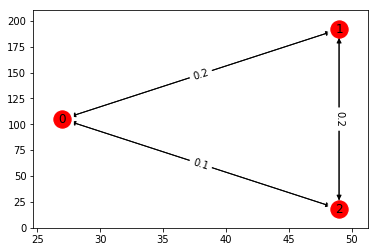

In [3]:
# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(states)
#print(r'Nodes:\n{G.nodes()}\n')

# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
#print('Edges:')
pprint(G.edges(data=True))    

pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos)

# create edge labels for jupyter plot but is not necessary
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'markov.dot')


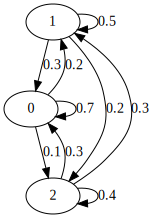

In [4]:
import graphviz

with open("markov.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

# hmmlearn package

In [37]:
import numpy as np
from hmmlearn import hmm
np.random.seed(42)

model = hmm.GaussianHMM(n_components=3, covariance_type="full")

model.startprob_ = np.array([0.6, 0.3, 0.1])
model.transmat_ = np.array([[0.7, 0.2, 0.1],
                            [0.3, 0.5, 0.2],
                            [0.3, 0.3, 0.4]])


model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [5.0, 10.0]])
model.covars_ = np.tile(np.identity(2), (3, 1, 1))
X, Z = model.sample(1000)

In [38]:
model.means_

array([[ 0.,  0.],
       [ 3., -3.],
       [ 5., 10.]])

Training HMM parameters and inferring the hidden states
You can train an HMM by calling the fit method. The input is a matrix of concatenated sequences of observations (aka samples) along with the lengths of the sequences (see Working with multiple sequences).

Note, since the EM algorithm is a gradient-based optimization method, it will generally get stuck in local optima. You should in general try to run fit with various initializations and select the highest scored model.

The score of the model can be calculated by the score method.

The inferred optimal hidden states can be obtained by calling predict method. The predict method can be specified with decoder algorithm. Currently the Viterbi algorithm ("viterbi"), and maximum a posteriori estimation ("map") are supported.

This time, the input is a single sequence of observed values. Note, the states in remodel will have a different order than those in the generating model.

  
### Hidden Markov Model with Gaussian emissions.

In [39]:
remodel = hmm.GaussianHMM(n_components=3,algorithm='viterbi', covariance_type="full", n_iter=100, 
                          verbose=True)
remodel.fit(X)

         1       -5107.5148             +nan
         2       -4186.4860        +921.0288
         3       -3792.4687        +394.0174
         4       -3709.2986         +83.1700
         5       -3691.7420         +17.5567
         6       -3686.9985          +4.7435
         7       -3686.0212          +0.9773
         8       -3685.8094          +0.2117
         9       -3685.7600          +0.0494
        10       -3685.7481          +0.0119
        11       -3685.7453          +0.0029


GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=3, n_iter=100, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=True)

In [40]:
print (model.means_)
print (remodel.means_)

[[ 0.  0.]
 [ 3. -3.]
 [ 5. 10.]]
[[-0.06737353  0.11087772]
 [ 4.97256265  9.97418181]
 [ 2.89804024 -2.85353782]]


In [41]:
print (model.covars_)
print (remodel.covars_)

[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]
[[[ 0.95037754  0.08186558]
  [ 0.08186558  0.93763333]]

 [[ 1.17915117  0.16712653]
  [ 0.16712653  1.01372292]]

 [[ 0.86084613 -0.02559351]
  [-0.02559351  0.93792638]]]


In [11]:
Z

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 2, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 0, 1, 1, 1, 1, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 1, 2, 2, 0, 0, 0, 1, 1, 1, 1,
       2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
remodel.predict(X)

array([3, 0, 3, 0, 0, 0, 3, 3, 3, 3, 3, 1, 2, 0, 0, 3, 0, 2, 0, 2, 1, 0,
       2, 2, 2, 0, 0, 0, 3, 3, 1, 1, 1, 1, 0, 2, 2, 2, 2, 1, 0, 3, 0, 0,
       3, 0, 3, 0, 0, 3, 0, 3, 1, 1, 2, 1, 2, 1, 1, 0, 0, 0, 2, 2, 2, 2,
       1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 3, 0, 3,
       0, 0, 2, 0, 3, 0, 0, 0, 3, 0, 0, 3])

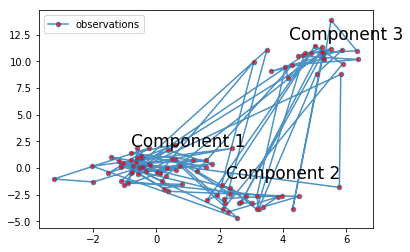

In [24]:

# Plot the sampled data
plt.plot(X[:, 0], X[:, 1], ".-", label="observations", ms=9,
         mfc="red", alpha=0.8)

# # Indicate the component numbers
for i, m in enumerate(model.means_):
    plt.text(m[0]+1, m[1]+2, 'Component %i' % (i + 1),
             size=17, horizontalalignment='center'
             #bbox=dict(alpha=.7, facecolor='w')
            )
plt.legend(loc='best')
plt.show()


In [47]:
print (remodel.transmat_)
print ('\n')
print (model.transmat_)

[[0.70510123 0.1058512  0.18904757]
 [0.24728622 0.41968912 0.33302466]
 [0.28376706 0.18713623 0.52909671]]


[[0.7 0.2 0.1]
 [0.3 0.5 0.2]
 [0.3 0.3 0.4]]
